In [1]:
import pandas as pd
import os

# Define the list of projects
projects = [
    "beam", "conductor", "dataease", "iceberg", "LSPosed",
    "metersphere", "SmartTubeNext", "spring-cloud-netflix", "supertokens-core", "wildfly"
]

# Function to load data with additional columns for Project and Filename
def load_data(file_path, project_name, file_column_name):
    # Load the dataset
    data = pd.read_csv(file_path)
    # Use os.path.basename to extract the filename from the full path stored in the specified file column
    data['Filename'] = data[file_column_name].apply(os.path.basename)
    # Add project name as a new column
    data['Project'] = project_name
    return data

In [2]:

# Load CK metrics and bad smells data for each project, with correct project and filename tagging
ck_metrics_combined = pd.concat(
    [load_data(f"C:/User/pavan/Final Project/Metrics/Ck metrics/{project}class.csv", project, 'file') for project in projects],
    ignore_index=True
)

bad_smells_combined = pd.concat(
    [load_data(f"C:/User/pavan/Final Project/Metrics/Bad smells/{project}_badsmells.csv", project, 'File') for project in projects],
    ignore_index=True
)

# Example to print the head of combined data to check
print(ck_metrics_combined.head())
print(bad_smells_combined.head())


                                                file  \
0  C:\User\pavan\Projects\beam\sdks\java\io\cassa...   
1  C:\User\pavan\Projects\beam\sdks\java\io\googl...   
2  C:\User\pavan\Projects\beam\sdks\java\io\rrio\...   
3  C:\User\pavan\Projects\beam\runners\samza\src\...   
4  C:\User\pavan\Projects\beam\sdks\java\extensio...   

                                               class        type  cbo  \
0  org.apache.beam.sdk.io.cassandra.DefaultObject...       class    5   
1  org.apache.beam.sdk.io.gcp.pubsub.PubsubDlqPro...       class    7   
2  org.apache.beam.io.requestresponse.CallTest$Un...  innerclass    2   
3  org.apache.beam.runners.samza.runtime.SamzaSto...   anonymous    3   
4  org.apache.beam.sdk.extensions.sketching.TDige...  innerclass    7   

   cboModified  fanin  fanout  wmc  dit  noc  ...  variablesQty  \
0            6      1       5    4    1    0  ...             1   
1            7      0       7    2    2    0  ...             0   
2            2      0  

In [3]:
bad_smells_combined.head()

,Problem,Package,File,Priority,Line,Description,Rule set,Rule,Filename,Project
0,1,org.apache.beam.testinfra.mockapis.echo.v1,C:\User\pavan\Projects\beam\.test-infra\mock-a...,3,80,"Possible God Class (WMC=51, ATFD=25, TCC=20.644%)",Design,GodClass,Echo.java,beam
1,2,org.apache.beam.testinfra.mockapis.echo.v1,C:\User\pavan\Projects\beam\.test-infra\mock-a...,3,83,"This class has too many methods, consider refa...",Design,TooManyMethods,Echo.java,beam
2,3,org.apache.beam.testinfra.mockapis.echo.v1,C:\User\pavan\Projects\beam\.test-infra\mock-a...,3,351,"Possible God Class (WMC=56, ATFD=16, TCC=17.196%)",Design,GodClass,Echo.java,beam
3,4,org.apache.beam.testinfra.mockapis.echo.v1,C:\User\pavan\Projects\beam\.test-infra\mock-a...,3,355,"This class has too many methods, consider refa...",Design,TooManyMethods,Echo.java,beam
4,5,org.apache.beam.testinfra.mockapis.echo.v1,C:\User\pavan\Projects\beam\.test-infra\mock-a...,3,423,Access to field `id_` on foreign value `result...,Design,LawOfDemeter,Echo.java,beam


In [8]:
# Ensure all columns with numeric data types are selected before calculating mean
numeric_columns = ck_metrics_combined.select_dtypes(include=[np.number]).columns
ck_metrics_mean_per_project = ck_metrics_combined.groupby('Project')[numeric_columns].mean()

# Grouping bad smells by file and type, counting occurrences and including the project information
bad_smells_count = bad_smells_combined.groupby(['Project', 'Filename', 'Rule']).size().reset_index(name='Count')

# Calculating mean count of each type of bad smell per project
bad_smells_mean_per_project = bad_smells_count.groupby(['Project', 'Rule'])['Count'].mean().reset_index()

# Reshape the bad smells data to have each rule type as a column for each project
bad_smells_mean_pivot = bad_smells_mean_per_project.pivot(index='Project', columns='Rule', values='Count').fillna(0)

# Combine the mean CK metrics with the mean counts of bad smells for each project
combined_project_metrics = ck_metrics_mean_per_project.join(bad_smells_mean_pivot).reset_index()

In [11]:
# Selecting 8 key metrics (CK Metrics and Bad Smells) to include in the final table for the paper
selected_metrics = [
    'cbo', 'wmc', 'dit', 
    'CyclomaticComplexity', 'GodClass', 'LawOfDemeter', 
    'UnusedLocalVariable', 'UnusedPrivateMethod'
]

# Dropping non-numeric columns like 'Project' before calculating the correlation matrix
numeric_project_metrics = combined_project_metrics[selected_metrics]

# Correlation Analysis: Calculating Pearson correlation coefficients for the selected metrics
correlation_matrix = numeric_project_metrics.corr(method='pearson')
correlation_matrix

,cbo,wmc,dit,CyclomaticComplexity,GodClass,LawOfDemeter,UnusedLocalVariable,UnusedPrivateMethod
cbo,1.000000,0.426513,0.310194,-0.431503,-0.097097,0.029230,0.155430,0.736351
wmc,0.426513,1.000000,0.371020,0.198000,0.304290,0.560728,0.009102,0.456632
dit,0.310194,0.371020,1.000000,0.161322,0.607124,0.654801,0.363338,0.276328
CyclomaticComplexity,-0.431503,0.198000,0.161322,1.000000,0.509695,0.179682,0.155575,-0.175664
GodClass,-0.097097,0.304290,0.607124,0.509695,1.000000,0.336397,0.652639,-0.163968
LawOfDemeter,0.029230,0.560728,0.654801,0.179682,0.336397,1.000000,-0.225716,0.284002
UnusedLocalVariable,0.155430,0.009102,0.363338,0.155575,0.652639,-0.225716,1.000000,0.023033
UnusedPrivateMethod,0.736351,0.456632,0.276328,-0.175664,-0.163968,0.284002,0.023033,1.000000


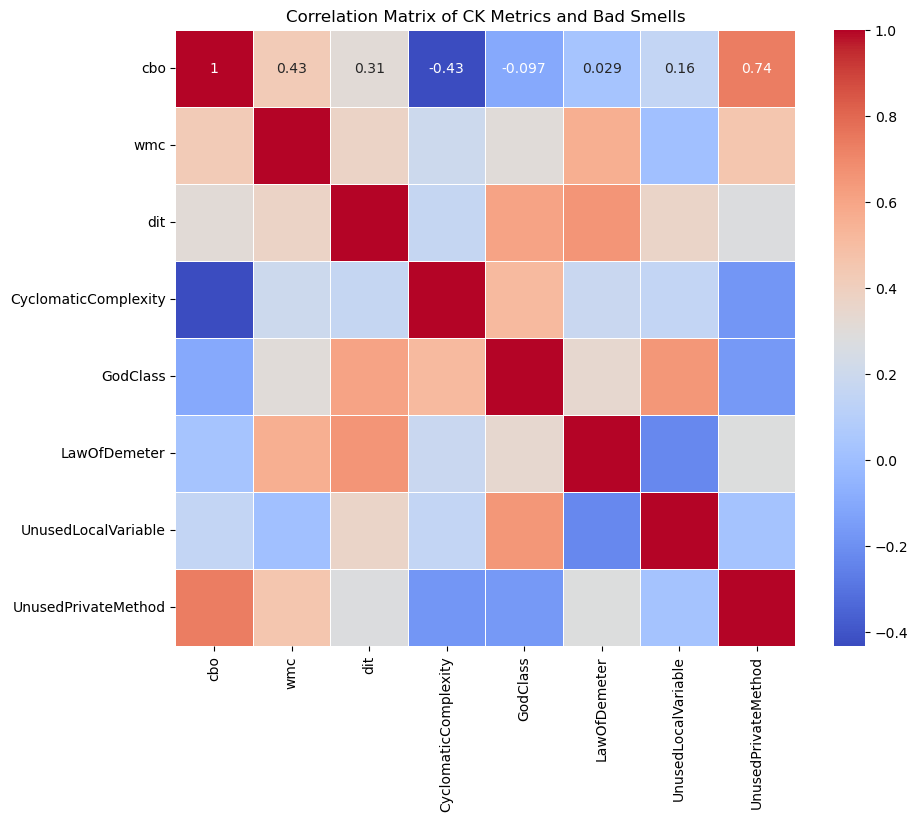

In [12]:
# Visualization: Correlation Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of CK Metrics and Bad Smells')
plt.show()


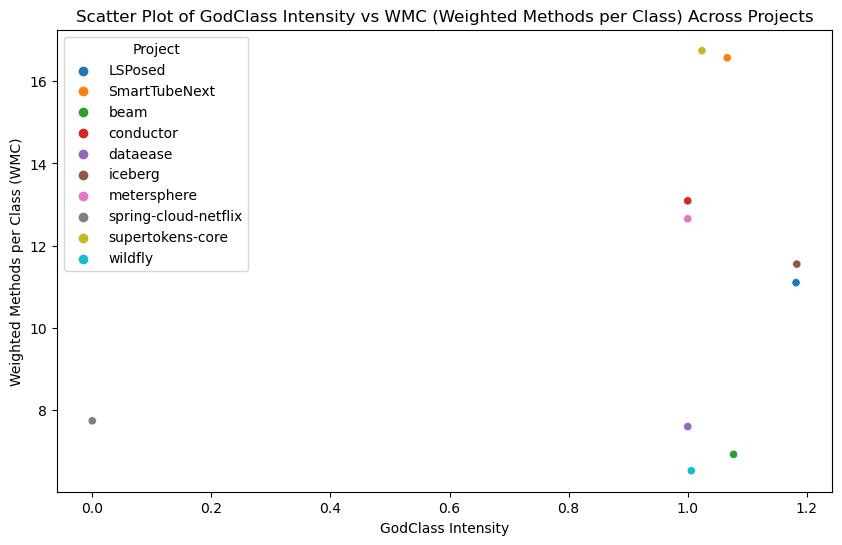

In [13]:
# Intra-Project Analysis: Scatter plot of 'GodClass' intensity vs 'wmc' within each project
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GodClass', y='wmc', hue='Project', data=selected_project_metrics)
plt.title('Scatter Plot of GodClass Intensity vs WMC (Weighted Methods per Class) Across Projects')
plt.xlabel('GodClass Intensity')
plt.ylabel('Weighted Methods per Class (WMC)')
plt.show()

Index(['file', 'class', 'type', 'cbo', 'cboModified', 'fanin', 'fanout', 'wmc',
       'dit', 'noc', 'rfc', 'lcom', 'lcom*', 'tcc', 'lcc', 'totalMethodsQty',
       'staticMethodsQty', 'publicMethodsQty', 'privateMethodsQty',
       'protectedMethodsQty', 'defaultMethodsQty', 'visibleMethodsQty',
       'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty',
       'totalFieldsQty', 'staticFieldsQty', 'publicFieldsQty',
       'privateFieldsQty', 'protectedFieldsQty', 'defaultFieldsQty',
       'finalFieldsQty', 'synchronizedFieldsQty', 'nosi', 'loc', 'returnQty',
       'loopQty', 'comparisonsQty', 'tryCatchQty', 'parenthesizedExpsQty',
       'stringLiteralsQty', 'numbersQty', 'assignmentsQty',
       'mathOperationsQty', 'variablesQty', 'maxNestedBlocksQty',
       'anonymousClassesQty', 'innerClassesQty', 'lambdasQty',
       'uniqueWordsQty', 'modifiers', 'logStatementsQty', 'Filename',
       'Project', 'Problem', 'Package', 'File', 'Priority', 'Line',
       'Descript

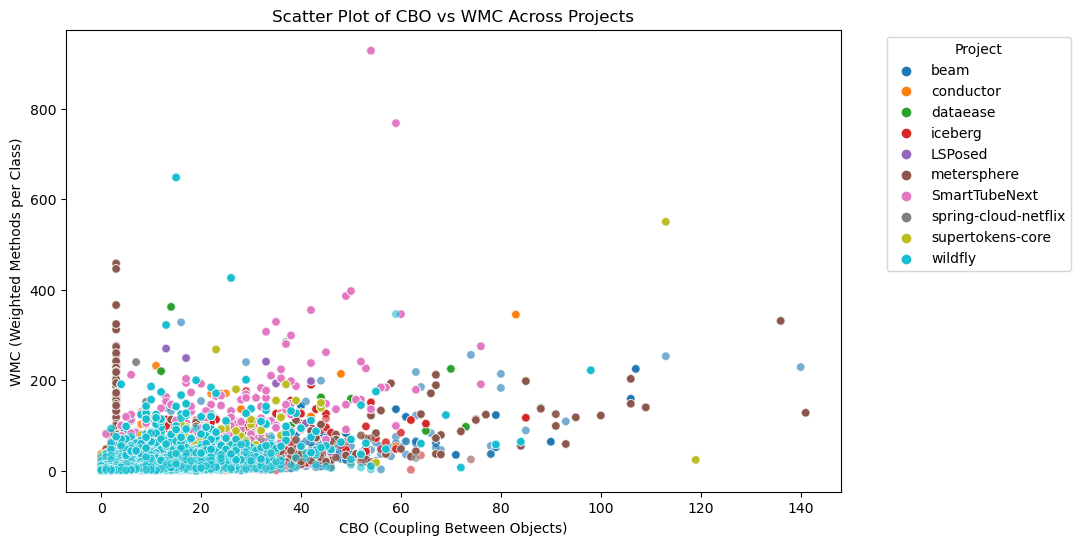

In [19]:
# Merge datasets on Project and Filename
combined_data = pd.merge(ck_metrics_combined, bad_smells_combined, left_on=['Project', 'Filename'], right_on=['Project', 'Filename'], how='left')

# Verify column names
print(combined_data.columns)

# Scatter Plot 1: Coupling Between Objects (CBO) vs. Weighted Methods per Class (WMC)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cbo', y='wmc', hue='Project', data=combined_data, alpha=0.6)
plt.title('Scatter Plot of CBO vs WMC Across Projects')
plt.xlabel('CBO (Coupling Between Objects)')
plt.ylabel('WMC (Weighted Methods per Class)')
plt.legend(title='Project', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

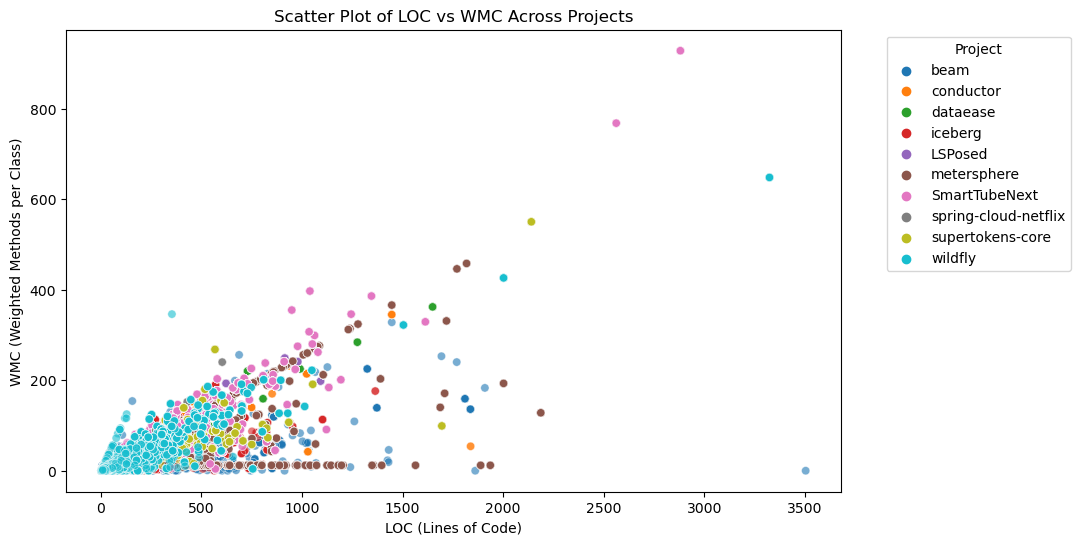

In [20]:
# Scatter Plot 2: Lines of Code (LOC) vs. Weighted Methods per Class (WMC)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='loc', y='wmc', hue='Project', data=combined_data, alpha=0.6)
plt.title('Scatter Plot of LOC vs WMC Across Projects')
plt.xlabel('LOC (Lines of Code)')
plt.ylabel('WMC (Weighted Methods per Class)')
plt.legend(title='Project', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()